In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
from scipy.io import wavfile
from numpy.fft import fft
from scipy import signal
from sklearn.preprocessing import scale
import pandas as pd
import os
import glob

try:
    os.chdir('piezo_data_01042016')
except:
    pass

In [3]:
def notch_filter_60(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 60 Hz filter
    bp_stop = np.array([58.0, 62.0])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

def notch_filter_16k(trace, fs=44100.0):
    """ digital notch filter to remove one frequency component from the data """
    # nyquist frequency
    fny = fs/2.0
    
    # create the 16100 Hz filter
    bp_stop = np.array([15950, 16050.0])
    b, a = signal.butter(2,bp_stop/fny, btype='bandstop', analog=False)
    
    # apply filter
    filtered = signal.filtfilt(b, a, trace)
    return filtered

def wav_to_df(filename, channel='left'):
    """ return arrays of time and sound amplitude """
    
    sampFreq, snd = wavfile.read(filename)

    # snd = snd / (2.**15) #convert sound array to float pt. values
    
    if channel == 'left':
        channel = 0
    elif channel == 'right':
        channel = 1
    else:
        raise ValueError('Pick a channel!')
    snd = snd[:,channel]
    
    N = len(snd)
    T = np.arange(0,N)/sampFreq
    
    filt = notch_filter_60(snd)
    filt = notch_filter_16k(filt)
    return pd.DataFrame({'T':T, 'A':snd, 'A_filt':filt})

def get_ft(trace, fs=44100):

    n = len(trace)
    dt = 1/fs # assume everything was taken at 44100 Hz

    xf = np.linspace(0.0, 1.0/(2.0*dt), n/2)

    yft = fft(trace)
    yft = yft*np.conjugate(yft)*(dt/n) # mV^2/Hz
    yft = np.sqrt(np.real(yft[:int(n/2)])) # mV/sqrt(Hz)
    
    return xf, yft

def window_fft(trace, width, window='hamming', overlap=0.5):
    """ average fft over windows of length width (in seconds) """
    fs = 44100.0
    pts = int(np.ceil(width*fs))
    step = int(pts*(1-overlap))
    starts = np.arange(0, len(trace)-pts, step)
    
    if starts[-1]+pts > len(trace)-1:
        starts = starts[:-1]

    if window=='square':
        window = np.ones(pts)
    elif window=='hamming':
        window = np.hamming(pts)
    elif window=='hanning':
        window = np.hanning(pts)
    else:
        raise ValueError('Pick a window!')

    fftall = np.zeros((len(starts),pts/2))
    
#     print(len(trace), pts, step)
    for i,start in enumerate(starts):
        sample = trace[start:start+pts]
#         print('sample {0}: {1} to {2}'.format(i, start, start+pts))
        xf, sample_fft = get_ft(sample*window)
        fftall[i,:] = sample_fft*2
    
    return xf, fftall

First, load wave files and save again with the right channel duplicated to the left so it is easier to listen to.

In [4]:
filelist = glob.glob('*.wav')

for f in filelist:
    sampFreq, snd = wavfile.read(f)
    snd[:,0] = snd[:,1]
    wavfile.write(f[:-4]+'_stereo.wav', sampFreq, snd)

Create a list of files, locations, and parameters

In [5]:
datasets = ['cryo_mc_ptoff_son_stereo.wav', 
            'cryo_mc_pton_soff_stereo.wav', 
            'cryo_mc_ptoff_soff_stereo.wav', 
            'cryo_mc_pton_soff_rvup_stereo.wav', 
            'cryo_mc_pton_soff_rvup-foam_stereo.wav', 
            'cryo_mc_pton_soff_balastup-foam_stereo.wav', 
            'cryo_mc_pton_soff_move-cables_stereo.wav', 
            'cryo_mc_pton_soff_lsout_stereo.wav',
            'cryo_mc_ptoff_soff_cson_stereo.wav',
            'cryo_mc_ptoff_soff_cson_ton_stereo.wav', 
            'cryo_mc_ptoff_440Hz_stereo.wav',
            'cryo_mc_ptoff_liquefieroff_stereo.wav',
            'cryo_mc_ptoff_liquefieron_stereo.wav'
            ]


labels = ['Big Scroll ON', 
         'PT ON', 
         'Background', 
         'RV UP, PT ON', 
         'RV UP+foam, PT ON', 
         'Balast UP+foam, PT ON', 
         'Move Cables, PT ON', 
         'LS OUT, PT ON', 
         'CS ON', 
         'CS ON, Turbo ON', 
         '440Hz Sound',
         'Liquifier OFF', 
         'Liquifier ON']

for i, names in enumerate(datasets):
    print(i, names, labels[i])

0 cryo_mc_ptoff_son_stereo.wav Big Scroll ON
1 cryo_mc_pton_soff_stereo.wav PT ON
2 cryo_mc_ptoff_soff_stereo.wav Background
3 cryo_mc_pton_soff_rvup_stereo.wav RV UP, PT ON
4 cryo_mc_pton_soff_rvup-foam_stereo.wav RV UP+foam, PT ON
5 cryo_mc_pton_soff_balastup-foam_stereo.wav Balast UP+foam, PT ON
6 cryo_mc_pton_soff_move-cables_stereo.wav Move Cables, PT ON
7 cryo_mc_pton_soff_lsout_stereo.wav LS OUT, PT ON
8 cryo_mc_ptoff_soff_cson_stereo.wav CS ON
9 cryo_mc_ptoff_soff_cson_ton_stereo.wav CS ON, Turbo ON
10 cryo_mc_ptoff_440Hz_stereo.wav 440Hz Sound
11 cryo_mc_ptoff_liquefieroff_stereo.wav Liquifier OFF
12 cryo_mc_ptoff_liquefieron_stereo.wav Liquifier ON


Going to make some effort to get the units right on the power spectrum so that I can extract proper peak heights later.

In [6]:
# at the soundcard input
u_to_V = 0.0243 # mV/unit

# the amplifier was at 40dB for the measurements in vacuum
gain = 100

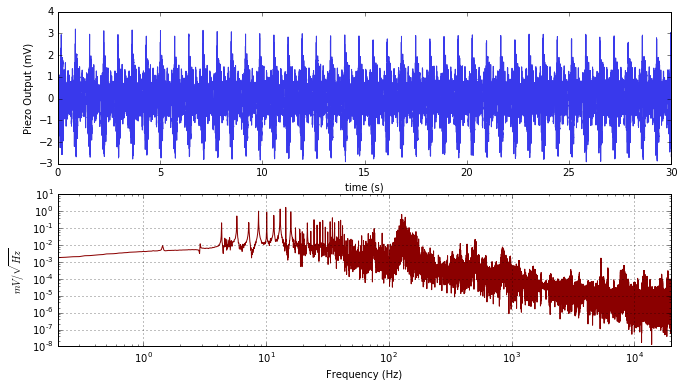

In [7]:
# move all folk lab data to dropbox
# get additional data from qdot26
# fix units -- DONE
# start dropping the first 3 seconds of data when doing averaging

fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100

df = wav_to_df(datasets[1], channel='right') # dataframe not frequency increment

t = df['T']
am = df['A']*u_to_V/gain
am_filt = df['A']*u_to_V/gain

n = len(am)
dt = 1/fs

xf = np.linspace(0.0, 1.0/(2.0*dt), n/2)

yft = fft(am_filt)
yft = yft*np.conjugate(yft)*(dt/n) # mV^2/Hz
yft = np.sqrt(np.real(yft[:int(n/2)])) # mV/sqrt(Hz)

fig, ax = plt.subplots(2,1, figsize=(11,6))

ax[0].plot(t, am, color = 'silver')
ax[0].plot(t, am_filt, color = 'blue', alpha=0.7)
ax[0].set_ylabel('Piezo Output (mV)')
ax[0].set_xlabel('time (s)')
ax[0].set_xlim(0,30)

ax[1].plot(xf, yft, color='darkred')
ax[1].grid()
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim(0.2,20e3)
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('$mV/\sqrt{Hz}$')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:81: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


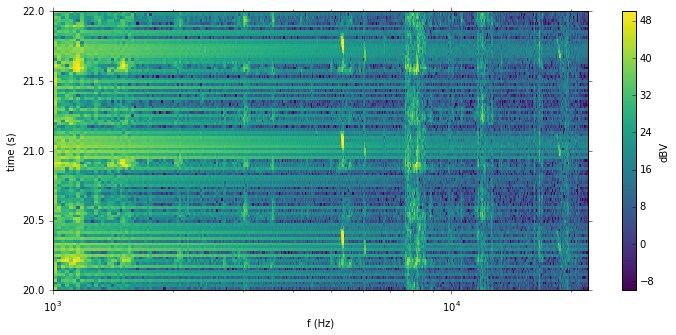

In [9]:
fs = 44100.0 # Hz
u_to_V = 0.0243 # mV
gain = 100
win = 0.04

# load wave and notch filtered data
df = wav_to_df(datasets[1], channel='right')
# start_time = 3.0
# df = df[df['T']>start_time]

xs, ffts = window_fft(df['A_filt']*u_to_V/gain, win, overlap=0.5)
ys = np.linspace(df['T'].iloc[0],df['T'].iloc[-1], len(ffts))
ffts = 20*np.log10(ffts*np.sqrt(n/dt)) # dBV

fig, ax = plt.subplots(1,1, figsize = (12,5))

pc = ax.pcolormesh(xs, ys, ffts, cmap=plt.cm.viridis, vmin=-10, vmax=50)
ax.set_xscale('log')
ax.set_xlim(1000, xs[-1])
ax.set_ylim(20,22)
ax.set_xlabel('f (Hz)')
ax.set_ylabel('time (s)')
ax.tick_params(which='both', direction='out')
cb = fig.colorbar(pc)
cb.set_label('dBV')

Loop through all data and save the above two plots.

In [440]:
# plot all FFTs averaged over 1 second windows

w = 8 # second

for i, f in enumerate(datasets):

    df = wav_to_df(f)
    df['A_filt'] *= u_to_V/gain
    xs, ffts = window_fft(df['A_filt'], w)
    signal_avg = np.mean(ffts, axis=0)

    fig, ax = plt.subplots(2,1, figsize=(11,6))

    ax[0].plot(df['T'], df['A_filt'], color = 'silver')
    ax[0].plot(t, am_filt, color = 'blue', alpha=0.7)
    ax[0].set_ylabel('Piezo Output (mV)')
    ax[0].set_xlabel('time (s)')
    ax[0].set_xlim(0,30)

    ax[1].plot(xs, signal_avg, color='darkred')
    ax[1].grid()
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_xlim(1/win,20e3)
    ax[1].set_xlabel('Frequency (Hz)')
    ax[1].set_ylabel('$mV/\sqrt{Hz}$')

FileNotFoundError: [Errno 2] No such file or directory: 'cryo_mc_ptoff_son_stereo.wav'

In [444]:
for f in glob.glob('*_stereo.wav'):
    print(f)

cyro_mc_aluminum_pton_stereo.wav
cyro_mc_brass_ptoff_stereo.wav
cyro_mc_brass_pton_stereo.wav
cyro_mc_ptoff_440Hz_stereo.wav
cyro_mc_ptoff_liquefieroff_stereo.wav
cyro_mc_ptoff_liquefieron_stereo.wav
cyro_mc_ptoff_soff_stereo.wav
cyro_mc_ptoff_son_stereo.wav
cyro_mc_ptoff_stereo.wav
cyro_mc_pton_soff_balastup-foam_stereo.wav
cyro_mc_pton_soff_cson_stereo.wav
cyro_mc_pton_soff_cson_ton_stereo.wav
cyro_mc_pton_soff_lsout_stereo.wav
cyro_mc_pton_soff_move-cables_stereo.wav
cyro_mc_pton_soff_rvup-foam_stereo.wav
cyro_mc_pton_soff_rvup_stereo.wav
cyro_mc_pton_soff_stereo.wav
cyro_mc_pton_stereo.wav


In [10]:
# plot FFTs as a function of time with fast and slow windows
# in these plots I'd like a low frequency and high frequency measurement on the left and right

fs = 44100.0 # Hz
fast_win = 0.01 # seconds
slow_win = 5
colormap = plt.cm.Reds

for i, names in enumerate(datasets):
    # load wave and notch filtered data
    df = wav_to_df(names[1])
    xsf, fftsf = window_fft(df['A_filt'], fast_win)
    signal_fast = np.mean(fftsf, axis=0)

    xss, fftss = window_fft(df['A_filt'], slow_win)
    signal_slow = np.mean(fftss, axis=0)

    df = wav_to_df(names[0])
    xbf, fftbf = window_fft(df['A_filt'], fast_win)
    back_fast = np.mean(fftbf, axis=0)

    xbs, fftbs = window_fft(df['A_filt'], slow_win)
    back_slow = np.mean(fftbs, axis=0)

    fig = plt.figure(figsize=(8,4))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1,1.5])
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[1,0], sharex=ax1)
    ax3 = plt.subplot(gs[0,1], sharey=ax1)
    ax4 = plt.subplot(gs[1,1], sharex=ax3, sharey=ax2)

    slow_extent = [xbs[0]/1000,xbs[-1]/1000,0,30]
    ax1.imshow(20*np.log10(fftbs), extent = slow_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax2.imshow(20*np.log10(fftss), extent = slow_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    fast_extent = [xbf[0]/1000,xbf[-1]/1000,0,30]
    ax3.imshow(20*np.log10(fftbf), extent = fast_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax4.imshow(20*np.log10(fftsf), extent = fast_extent, cmap = colormap, vmin=-180, vmax=-50.0, 
                 origin='lower', aspect='auto', interpolation='nearest')

    ax2.set_xlim(0,1)
    ax4.set_xlim(0,20)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.setp(ax4.get_yticklabels(), visible=False)
    ax2.set_xlabel('Frequency (kHz)')
    ax4.set_xlabel('Frequency (kHz)')
    ax1.set_ylabel('time (s)')
    ax2.set_ylabel('time (s)')
    title = '({0:d}) {1} -- {2} ON/OFF'.format(i, locations[i], onoff[i])
    ax3.set_title(title)
    output = 'plots/'+'{0}_{1}_time_fft'.format(locations[i].replace(' ', '_'), onoff[i])
    gs.tight_layout(fig)
    fig.savefig(output, dpi=300)
    plt.close()

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Make some plots of peak heights that represent different noise ranges... 4.2Hz, 140Hz, 8.2kHz

Maybe make some plots of integrated noise power in similar ranges... 0-20Hz, 200-2000Hz, 5000-10000Hz